## Title :
Bayes PyMC3

## Description :
Run this notebook in your own environment. Do not forget to download the images/ and data/ folders.

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lecture 10 - Bayesian Analysis and Introduction to pyMC3

**Harvard University**<br>
**Spring 2021**<br>
**Instructors:** Pavlos Protopapas, Mark Glickman, and Chris Tanner<br>
**Additional Instructor and content:** Eleni Angelaki Kaxiras<br>

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [43]:
import pymc as pm
# from pymc3 import summary
import arviz as az
from matplotlib import gridspec
# Ignore a common pymc3 warning that comes from library functions, not our code.
# Pymc3 may throw additional warnings, but other warnings should be manageable
# by following the instructions included within the warning messages.
import warnings
messages=[
    "Using `from_pymc3` without the model will be deprecated in a future release",
]

# or silence all warnings (not recommended)
# warnings.filterwarnings('ignore')

for m in messages:
    warnings.filterwarnings("ignore", message=m)
print(f"Using PyMC3 version: {pm.__version__}")
print(f"Using ArviZ version: {az.__version__}")

Using PyMC3 version: 5.5.0
Using ArviZ version: 0.15.1


In [3]:
from scipy import optimize

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
%matplotlib inline 

In [5]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 20000;
# %%javascript magic command at the beginning. It instructs the Jupyter Notebook to interpret the following code as JavaScript, 
# allowing you to modify the notebook's behavior using JavaScript syntax.

<IPython.core.display.Javascript object>

In [8]:
# pandas trick
pd.options.display.max_columns = 50  # or =None -> No Restrictions
pd.options.display.max_rows = 200    # or =None -> *Be careful with this* 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

## Learning Objectives

By the end of this lab, you should be able to:
* identify and describe some of the most important probability distributions.
* apply Bayes Rule in calculating probabilities (and would have had fun in the process).
* create probabilistic models in the PyMC3 library. 

<a id=top></a>

## Table of Contents
1. [Some common families of distributions (review)](#1)
2. [The Bayesian Way of Thinking](#2) 
3. [Bayesian Regression with pyMC3](#3) and [Defining a model in pyMC3](#model)   
4. [Bayesian Logistic Regression with pyMC3](#4)<BR><BR>
[Appendix](#appe)

<a id=1></a>

## 1. Some common families of distributions

Statistical distributions are characterized by one of more parameters, such as $\mu$ and $\sigma^2$ for a Gaussian distribution. 

\begin{equation}
Y \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation}  
<HR>
    
### Discrete Distributions

The **probability mass function (pmf)** of a discrete random variable $Y$ is equal to the probability that our random variable will take a specific value $y$: $f_y=P(Y=y)$ for all $y$. The variable, most of the times, assumes integer values.  Plots for **pmf**s are better understood as stem plots since we have discrete values for the probabilities and not a curve. Probabilities should add up to 1 for proper distributions. 

- **Bernoulli** for a binary outcome, success has probability $\theta$, and we only have $one$ trial:<BR>
    
\begin{equation}
P(Y=k) =  \theta^k(1-\theta)^{1-k}
\end{equation}  

    
- **Binomial** for a binary outcome, success has probability $\theta$, $k$ successes in $n$ trials:

Our random variable is $Y$= number of successes in $n$ trials.

\begin{equation}
P(Y=k|n,\theta) =  {{n}\choose{k}} \cdot \theta^k(1-\theta)^{n-k} \quad k=0,1,2,...,n
\end{equation}
<BR>
As a reminder ${{n}\choose{k}}$ is "from $n$ choose $k$":
\begin{equation}
{{n}\choose{k}} = \frac{n!}{k!(n-k)!} 
\end{equation}

$EY=n\theta$, $VarY = np(1-p)$     

**Note** : Binomial (1,$p$) = Bernouli ($p$)  
<BR>

<div class="exercise"><b>Exercise</b>: Run the code below (that plots the Binomial distribution using <I>stats.binom.pmf</I>) for various values of the probability for a success $\theta\in [0,1]$. Look at the ordinate values to verify that they add up to 1.</div>

[0 1 2 3 4 5]


/tmp/ipykernel_147240/1056452707.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


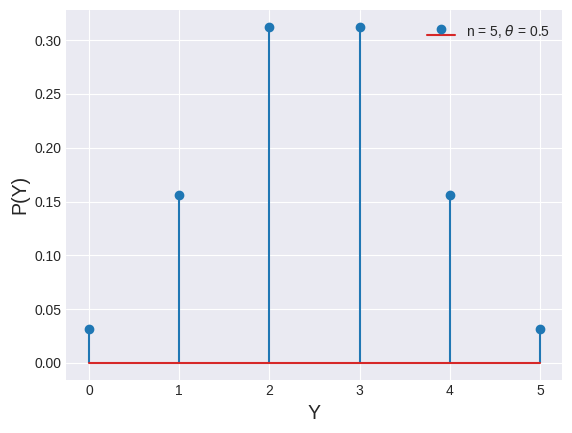

In [9]:
# probabity of success
theta = 0.5
n = 5
k = np.arange(0, n+1)
print(k)
pmf = stats.binom.pmf(k, n, theta)
plt.style.use('seaborn-darkgrid')
# !!!!!!
plt.stem(k, pmf, label=r'n = {}, $\theta$ = {}'.format(n, theta))
# !!!!!!!!!!!
# A stem plot draws lines perpendicular to a baseline at each location locs from the baseline to heads, and places a marker there.
plt.xlabel('Y', fontsize=14)
plt.ylabel('P(Y)', fontsize=14)
plt.legend()
plt.show()

    
- **Negative Binomial** for a binary outcome, success has probability $\theta$, we have $r$ successes in $x$ trials:

Our random variable is $X$= number of trials to get to $r$ successes.

\begin{equation}
P(X=x|r,\theta) =  {{x-1}\choose{r-1}} \cdot \theta^r(1-\theta)^{x-r} \quad x=r,r+1,...
\end{equation}
<BR>

- **Poisson** (counts independent events and has a single parameter $\lambda$)<bR>
    
\begin{equation}
P\left( Y=y|\lambda \right) = \frac{{e^{ - \lambda } \lambda ^y }}{{y!}} \quad y = 0,1,2,...
\end{equation}


<div class="exercise"><b>Exercise</b>: Change the value of $\lambda$ in the Poisson pmf plot below and see how the plot changes. Remember that the y-axis in a discrete probability distribution shows the probability of the random variable having a specific value in the x-axis. We use <I>stats.poisson.pmf(x, $\lambda$)</I>, where $\lambda$ is the parameter.</div>

/tmp/ipykernel_147240/3094468324.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


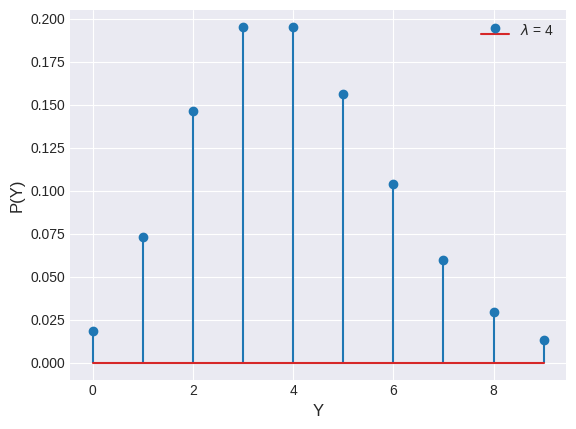

In [18]:
plt.style.use('seaborn-darkgrid')
x = np.arange(0, 10)
lam = 4
pmf = stats.poisson.pmf(x, lam)
plt.stem(x, pmf, label='$\lambda$ = {}'.format(lam))
plt.xlabel('Y', fontsize=12)
plt.ylabel('P(Y)', fontsize=12)
plt.legend(loc=1)
plt.ylim=(-0.1)
plt.show()

- **Discrete Uniform** for a random variable $X\in(1,N)$:<BR>
    
\begin{equation}
P(X=x|N) = \frac{1}{N}, \quad x=1,2,...,N
\end{equation} 

/tmp/ipykernel_147240/3206037709.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


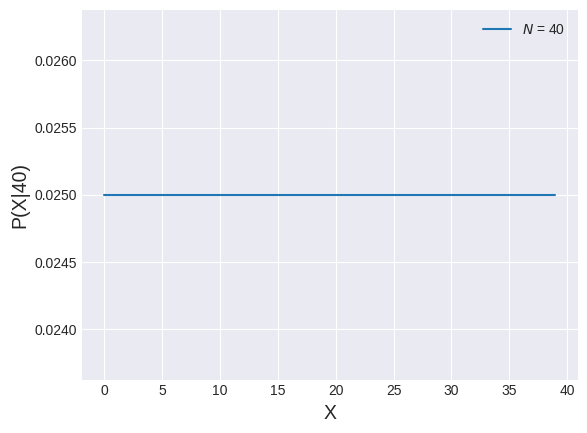

In [11]:
# boring but useful as a prior
plt.style.use('seaborn-darkgrid')
N = 40
x = np.arange(0, N)
pmf = stats.randint.pmf(x, 0, N)
# pmf(k, low, high, loc=0)
plt.plot(x, pmf, label='$N$ = {}'.format(N))
fontsize=14
plt.xlabel('X', fontsize=fontsize)
plt.ylabel(f'P(X|{N})', fontsize=fontsize)
plt.legend()
plt.show()

- **Categorical, or Multinulli** (random variables can take any of K possible categories, each having its own probability; this is a generalization of the Bernoulli distribution for a discrete variable with more than two possible outcomes, such as the roll of a die)

\begin{equation}
f(x_1,x_2,...,x_n) =  \frac{m!}{x_1!\cdot x_2!\dotsb x_n!} \cdot p_1^{x_1}\cdot p_2^{x_2}\dotsb p_n^{x_n}
\end{equation}


m is the total number of trials or observations.

x1,x2,…,xnx1​,x2​,…,xn​ are the counts or frequencies of the different outcomes, such that x1+x2+⋯+xn=mx1​+x2​+⋯+xn​=m.

p1,p2,…,pnp1​,p2​,…,pn​ are the probabilities of the different outcomes, and they must satisfy the condition p1+p2+⋯+pn=1p1​+p2​+⋯+pn​=1.

x1!,x2!,…,xn!x1​!,x2​!,…,xn​! represent the factorials of the counts x1,x2,…,xnx1​,x2​,…,xn​.


<HR>
    
### Continuous Distributions

The random variable has a **probability density function (pdf)** whose area under the curve equals to 1.
- **Uniform** (variable equally likely to be near each value in interval $(a,b)$)
\begin{equation}
f(x|a,b) = \frac{1}{b - a} \quad x\in [a,b] \quad \text{and 0 elsewhere}.
\end{equation} 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!

<div class="exercise"><b>Exercise</b>: Change the value of $\mu$ in the Uniform PDF and see how the plot changes.</div>
   
Remember that the y-axis in a continuous probability distribution does not shows the actual probability of the random variable having a specific value in the x-axis because that probability is zero!. Instead, to see the probability that the variable is within a small margin we look at the integral below the curve of the PDF.

The uniform is often used as a noninformative prior.

```
Uniform - numpy.random.uniform(a=0.0, b=1.0, size)
```

$\alpha$ and $\beta$ are our parameters. `size` is how many tries to perform.
The mean is $\mu = \frac{(a+b)}{2}$


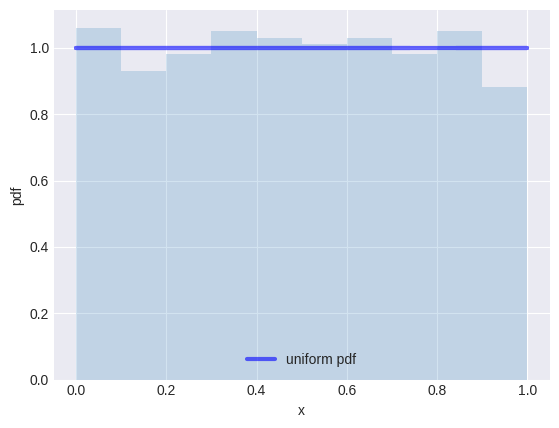

In [12]:
from scipy.stats import uniform
a = 0
b = 1
r = uniform.rvs(loc=a, scale=b-a, size=1000) 
# generate random samples from a continuous uniform distribution. 
# rvs(loc=0, scale=1, size=1, random_state=None)
# The loc parameter sets the lower bound of the distribution, scale sets the range of the distribution

pdf = uniform.pdf(r,loc=a, scale=b-a)
plt.plot(r, pdf,'b-', lw=3, alpha=0.6, label='uniform pdf')
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
# !!!!!!!!!!!!
# in the sample, the frequencies of generated value (r) may vary
# but when using uniform.pdf(the equations) the probabilities are the same for each value
plt.ylabel(r'pdf')
plt.xlabel(f'x')
plt.legend(loc='best', frameon=False)
plt.show()

- **Normal** (a.k.a. Gaussian)
\begin{equation}
X \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

    A Normal distribution can be parameterized either in terms of precision $\tau$ or variance $\sigma^{2}$. The link between the two is given by
\begin{equation}
\tau = \frac{1}{\sigma^{2}}
\end{equation}
 - Expected value (mean) $\mu$
 - Variance $\frac{1}{\tau}$ or $\sigma^{2}$
 - Parameters: `mu: float`, `sigma: float` or `tau: float`
 - Range of values (-$\infty$, $\infty$)

/tmp/ipykernel_147240/511046028.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


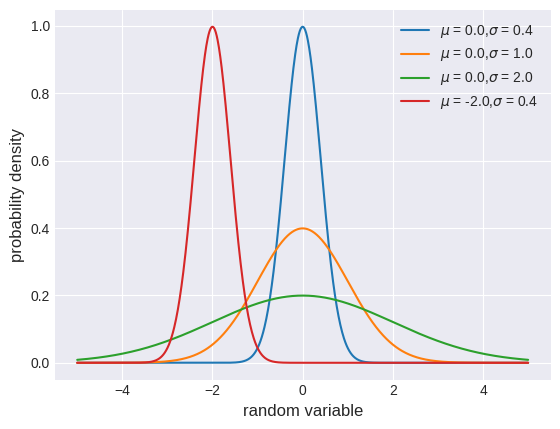

In [13]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(-5, 5, 1000)
mus = [0., 0., 0., -2.]
sigmas = [0.4, 1., 2., 0.4]
for mu, sigma in zip(mus, sigmas):
    pdf = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, label=r'$\mu$ = '+ f'{mu},' + r'$\sigma$ = ' + f'{sigma}') 
plt.xlabel('random variable', fontsize=12)
plt.ylabel('probability density', fontsize=12)
plt.legend(loc=1)
plt.show()

- **Beta** (where the variable ($\theta$) takes on values in the interval $(0,1)$, and is parametrized by two positive parameters, $\alpha$ and $\beta$ that control the shape of the distribution. Note that Beta is a good distribution to use for priors (beliefs) because its range is $[0,1]$ which is the natural range for a probability and because we can model a wide range of functions by changing the $\alpha$ and $\beta$ parameters. Its density (pdf) is:

\begin{equation}
\label{eq:beta} 
P(\theta|a,b) = \frac{1}{B(\alpha, \beta)} {\theta}^{\alpha - 1} (1 - \theta)^{\beta - 1} \propto {\theta}^{\alpha - 1} (1 - \theta)^{\beta - 1}
\end{equation}

where the normalisation constant, $B$, is a beta function of $\alpha$ and $\beta$,


\begin{equation}
B(\alpha, \beta) = \int_{x=0}^1 x^{\alpha - 1} (1 - x)^{\beta - 1} dx.
\end{equation}
 - 'Nice', unimodal distribution
 - Range of values $[0, 1]$

$EX = \frac{a}{a+b}$,    $VarX = \frac{ab}{(a+b)^2(a+b+1)}$
<BR><BR>
<div class="exercise"><b>Exercise</b>: Try out various combinations of $a$ and $b$. We get an amazing set of shapes by tweaking the two parameters $a$ and $b$. Notice that for $a=b=1.$ we get the uniform distribution. As the values increase, we get a curve that looks more and more Gaussian. </div>

/tmp/ipykernel_147240/2686331301.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


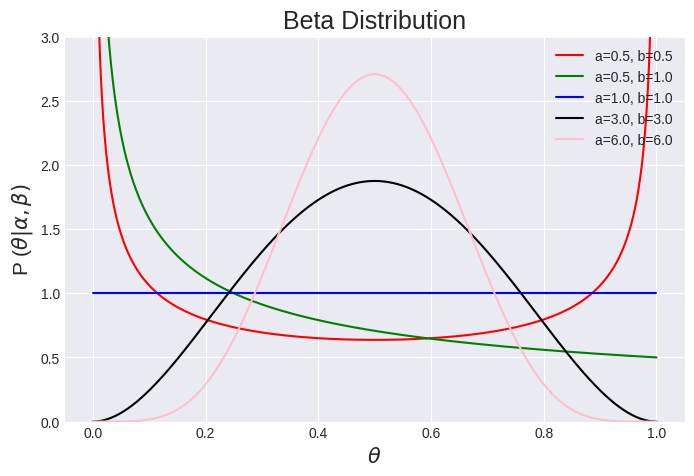

In [24]:
from scipy.stats import beta

fontsize = 15
alphas = [0.5, 0.5, 1., 3., 6.]
betas = [0.5, 1., 1., 3., 6.]
x = np.linspace(0, 1, 1000) 
colors = ['red', 'green', 'blue', 'black', 'pink']

fig, ax = plt.subplots(figsize=(8, 5))

for a, b, colors in zip(alphas, betas, colors):
    plt.plot(x, beta.pdf(x,a,b), c=colors,
             label=f'a={a}, b={b}')

ax.set_ylim(0, 3)

ax.set_xlabel(r'$\theta$', fontsize=fontsize)
ax.set_ylabel(r'P ($\theta|\alpha,\beta)$', fontsize=fontsize)
ax.set_title('Beta Distribution', fontsize=fontsize*1.2)

ax.legend(loc='best')
fig.show();

In [22]:
for a, b, colors in zip(alphas, betas, colors):
    print(a, b, colors)

0.5 0.5 r


<div class="discussion"> <b>At home</b>: Prove the formula mentioned in class which gives the probability density for a Beta distribution with parameters $2$ and $5$:<BR>
$p(\theta|2,5) = 30 \cdot \theta(1 - \theta)^4$

 #### Code Resources:
 - Statistical Distributions in numpy/scipy: [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)

<a id=2></a> [Top](#top)

## 2. The Bayesian way of Thinking

```
Here is my state of knowledge about the situation. Here is some data, I am now going to revise my state of knowledge.
```

### Bayes Rule

\begin{equation}
\label{eq:bayes} 
P(A|\textbf{B}) = \frac{P(\textbf{B} |A) P(A) }{P(\textbf{B})} 
\end{equation}

$P(A|\textbf{B})$ is the **posterior** distribution, probability(parameters| data). 

$P(\textbf{B} |A)$ is the **likelihood** function, how probable is my data for different values of the parameters.

$P(A)$ is the marginal probability to observe the data, called the **prior**, this captures our belief about the data before observing it.

$P(\textbf{B})$ is the marginal distribution (sometimes called marginal likelihood). This serves a normalization purpose.

### Let's Make a Deal  
<img src="images/montyhall.png">
    
The problem we are about to solve gained fame as part of a game show "Let's Make A Deal" hosted by Monty Hall, hence its name. It was first raised by Steve Selvin in American Statistician in 1975.
    
The game is as follows: there are 3 doors behind **one** of which are the keys to a new car. There is a goat behind each of the other two doors. Let's assume your goal is to get the car and not a goat.

You are asked to pick one door, and let's say you pick **Door1**. The host knows where the keys are. Of the two remaining closed doors, he will always open the door that has a goat behind it. He'll say "I will do you a favor and open **Door2**". So he opens Door2 inside which there is, of course, a goat. He now asks you, do you want to open the initial Door1 you chose or change to **Door3**? Generally, in this game, when you are presented with this choice should you swap the doors?<BR><BR>
**Hint:**
- Start by defining the `events` of this probabilities game. One definition is:
    
    - $A_i$: car is behind door $i$    
        
    - $B_i$ host opens door $i$
    
$i\in[1,2,3]$
      
- In more math terms, the question is: is the probability of **the price is behind Door 1** higher than the probability of **the price is behind Door2**, given that an event **has occured**?
 

<div class="exercise" style="background-color:#b3e6ff"><b>Breakout Game</b>: Solve the Monty Hall Paradox using Bayes Rule.<BR></div>

### Bayes rule revisited 

We have data that we believe come from an underlying distribution of unknown parameters. If we find those parameters, we know everything about the process that generated this data and we can make inferences (create new data).

\begin{equation}
P(\theta|\textbf{D}) = \frac{P(\textbf{D} |\theta) P(\theta) }{P(\textbf{D})} 
\end{equation}

#### But what is $\theta \;$?

$\theta$ is an unknown yet fixed set of parameters. In Bayesian inference we express our belief about what $\theta$ might be and instead of trying to guess $\theta$ exactly, we look for its **probability distribution**. What that means is that we are looking for the **parameters** of that distribution. For example, for a Poisson distribution our $\theta$ is only $\lambda$. In a normal distribution, our $\theta$ is often just $\mu$ and $\sigma$.

<a id=3></a> [Top](#top)

## 3. Bayesian Regression with `pyMC3`
 
PyMC3 is a Python library for programming Bayesian analysis, and more specifically, data creation, model definition, model fitting, and posterior analysis. It uses the concept of a `model` which contains assigned parametric statistical distributions to unknown quantities in the model. Within models we define random variables and their distributions. A distribution requires at least a `name` argument, and other `parameters` that define it. You may also use the `logp()` method in the model to build the model log-likelihood function. We define and fit the model.

PyMC3 includes a comprehensive set of pre-defined statistical distributions that can be used as model building blocks. They are not meant to be used outside of a `model`, and you can invoke them by using the prefix `pm`, as in `pm.Normal`. 

For more see: [PyMC3 Quickstart](https://docs.pymc.io/notebooks/api_quickstart.html)

 ### Distributions in `PyMC3`:
 - Statistical [Distributions in pyMC3](https://docs.pymc.io/api/distributions.html). 
 
Information about PyMC3 functions including descriptions of distributions, sampling methods, and other functions, is available via the `help` command.

In [25]:
help(pm.Beta)

Help on class Beta in module pymc3.distributions.continuous:

class Beta(UnitContinuous)
 |  Beta(alpha=None, beta=None, mu=None, sigma=None, sd=None, *args, **kwargs)
 |  
 |  Beta log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \alpha, \beta) =
 |         \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(0, 1, 200)
 |      alphas = [.5, 5., 1., 2., 2.]
 |      betas = [.5, 1., 3., 2., 5.]
 |      for a, b in zip(alphas, betas):
 |          pdf = st.beta.pdf(x, a, b)
 |          plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
 |      plt.xlabel('x', fontsize=12)
 |      plt.ylabel('f(x)', fontsize=12)
 |      plt.ylim(0, 4.5)
 |      plt.legend(loc=9)
 |      plt.show()
 |  
 |  ========  ================================

### Defining a Model in PyMC3

Our problem is the following: we want to perform multiple linear regression to predict an outcome variable $Y$ which depends on variables $\bf{x}_1$ and $\bf{x}_2$.

We will model $Y$ as normally distributed observations with an expected value $mu$ that is a linear function of the two predictor variables, $\bf{x}_1$ and $\bf{x}_2$.

\begin{equation}
Y \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

\begin{equation}
\mu = \beta_0 + \beta_1 \bf{x}_1 + \beta_2 x_2 
\end{equation}

where $\sigma^2$ represents the measurement error (in this example, we will use $\sigma^2 = 10$)

We also choose the parameters to have normal distributions with those parameters set by us.

\begin{eqnarray}
\beta_i \sim  \mathcal{N}(0,\,10) \\
\sigma^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}   
We will artificially create the data to predict on. We will then see if our model predicts them correctly.

#### Let's create some synthetic data 

In [26]:
np.random.seed(123)

###################################
## Hidden true parameter values 
sigma = 1
beta0 = 1
beta = [1, 2.5]   
####################################

# Size of dataset
size = 100

# Predictor variable
x1 = np.linspace(0, 1., size)
x2 = np.linspace(0,2., size)

# Simulate outcome variable
Y = beta0 + beta[0]*x1 + beta[1]*x2 + np.random.randn(size)*sigma
# np.random.randn Return a sample (or samples) from the “standard normal” distribution.
# The standard normal distribution has a mean of 0 and a standard deviation of 1.

In [27]:
Y.shape, x1.shape, x2.shape

((100,), (100,), (100,))

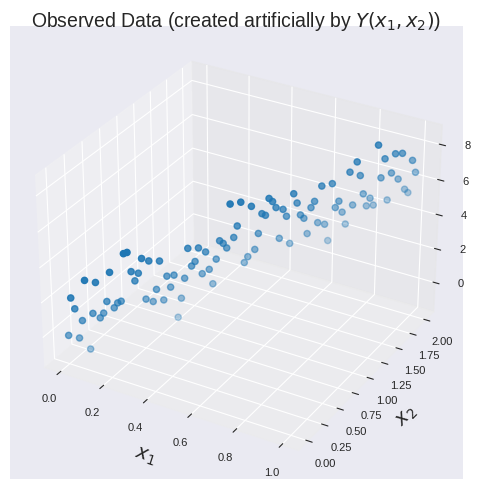

In [33]:
from mpl_toolkits.mplot3d import Axes3D
# !!!!!!!!!!!!
fig = plt.figure()
fontsize=14
labelsize=8
title='Observed Data (created artificially by ' + r'$Y(x_1,x_2)$)'
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, Y)
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.set_zlabel(r'$Y$', fontsize=fontsize)

ax.tick_params(labelsize=labelsize)

fig.suptitle(title, fontsize=fontsize)        
fig.tight_layout(pad=.1, w_pad=10.1, h_pad=2.)
fig.subplots_adjust(); #top=0.5
plt.tight_layout
plt.show()

#### Building the model

**Step1:** Formulate the probability model for our data: $Y \sim  \mathcal{N}(\mu,\,\sigma^{2})$

```
Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
```

**Step2:** Choose a prior distribution for our unknown parameters. 
```
 beta0 = Normal('beta0', mu=0, sd=10)
 # Note: betas is a vector of two variables, b1 and b2, (denoted by shape=2)
 # so, in array notation, our beta1 = betas[0], and beta2=betas[1]
 betas = Normal('betas', mu=0, sd=10, shape=2) 
 sigma = HalfNormal('sigma', sd=1)

```
**Step3:** Construct the likelihood function.

**Step4:** Determine the posterior distribution, **this is our main goal**.

**Step5:** Summarize important features of the posterior and/or plot the parameters.

In [46]:
with pm.Model() as my_linear_model:

    # Priors for unknown model parameters, specifically created stochastic random variables 
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations.
    # These are our parameters.
    
    # I need to give the prior some initial values for the parameters
    mu0 = 0
    sd0 = 10
    beta0 = pm.Normal('beta0', mu=mu0, sigma=sd0)    
    # Note: betas is a vector of two variables, b1 and b2, (denoted by shape=2)
    # so, in array notation, our beta1 = betas[0], and beta2=betas[1]
    mub = 0
    sdb = 10
    betas = pm.Normal('betas', mu=mub, sigma=sdb, shape=2) 
    sds = 1
    sigma = pm.HalfNormal('sigma', sigma=sds)
    
    # mu is what is called a deterministic random variable, which implies that 
    # its value is completely determined by its parents’ values 
    # (betas and sigma in our case). There is no uncertainty in the 
    # variable beyond that which is inherent in the parents’ values
    
    mu = beta0 + betas[0]*x1 + betas[1]*x2
    
    # Likelihood function = how probable is my observed data?
    # This is an observed variable; it is identical to a standard 
    # stochastic variable, except that its observed argument, 
    # which passes the data to the variable, indicates that the values for this 
    # variable were observed, and should not be changed by any 
    # fitting algorithm applied to the model. 
    # The data can be passed in the form of a numpy.ndarray or pandas.DataFrame object.
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

In [47]:
my_linear_model.basic_RVs

[beta0, betas, sigma, Y_obs]

In [48]:
my_linear_model.free_RVs

[beta0, betas, sigma]

**Note**: If our problem was a classification for which we would use Logistic regression.

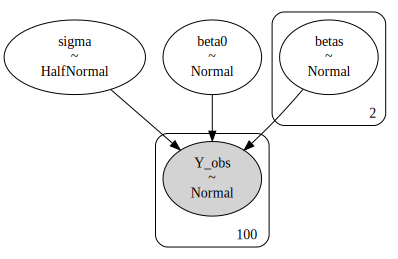

In [49]:
## do not worry if this does not work, it's just a nice graph to have
## you need to install python-graphviz first
# conda install -c conda-forge python-graphviz
pm.model_to_graphviz(my_linear_model)

Now all we need to do is sample our model.

### ... to be continued

<a id=appeA></a> 

## Appendix A: Bayesian Logistic Regression with `pyMC3`

If the problem above was a classification that required a Logistic Regression, we would use the logistic function ( where $\beta_0$ is the intercept, and $\beta_i$ (i=1, 2, 3) determines the shape of the logistic function).

\begin{equation}
Pr(Y=1|X_1,X_2,X3) = {\frac{1}{1 + exp^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3)}}}
\end{equation}

Since both $\beta_0$ and the $\beta_i$s can be any possitive or negative number, we can model them as gaussian random variables.

\begin{eqnarray}
\beta_0 \sim  \mathcal{N}(\mu,\,\sigma^2) \\
\beta_i \sim  \mathcal{N}(\mu_i,\,\sigma_i^2)
\end{eqnarray} 

In PyMC3 we can model those as:
```
pm.Normal('beta_0', mu=0, sigma=100)
```
(where $\mu$ and $\sigma^2$ can have some initial values that we assign them, e.g. 0 and 100)

The dererministic variable would be:
```
logitp = beta0 + beta_1 * X_1 + beta_2 * X_2 + beta_3 * X_3
```
To connect this variable (logit-p) with our observed data, we would use a Bernoulli as our likelihood.
```
our_likelihood = pm.Bernoulli('our_likelihood', logit_p=logitp, observed=our_data)
```

Notice that the main difference with Linear Regression is the use of a Bernoulli distribution instead of a Gaussian distribution, and the use of the logistic function instead of the identity function.

In [ ]:
with pm.Model() as logistic_model:
    beta0 = pm.Normal("beta0", mu = 0, sigma = 100)
    betas = pm.Normal("betas", mu = 0, sigma = 100, shape = 2)
    logitp = beta0 + beta[0] * df_train["age"] + beta[1] * df_train["weight"]
    y_obs = pm.Bernoulli("y", logit_p = logitp, observed = df_train["hypertension"])
    # pm.Bernoulli accepts both logit_p and p

<div class="exercise" style="background-color:#b3e6ff"><b>Breakout Room Exercise</b>: Write the model above in code. Suppose that your training dataframe (df_train) has the following features:

**numerical**
- df_train['age']
- df_train['weight'] 
    
**categorical**
- df_train['hypertension'] 

</div>

Text(0, 0.5, 'y=logistic(x)')

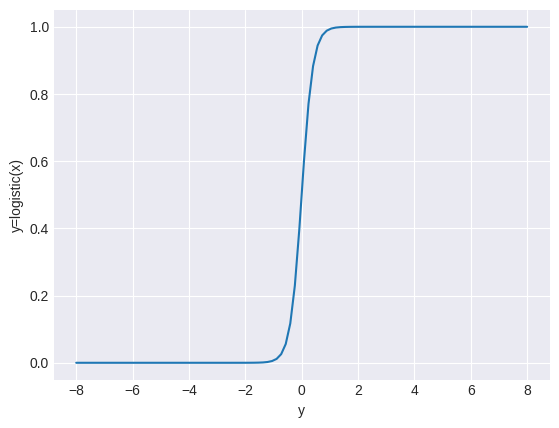

In [50]:
# A reminder of what the logistic function looks like. 
# Change parameters a and b to see the shape of the curve change
b = 5.
x = np.linspace(-8, 8, 100)
plt.plot(x, 1 / (1 + np.exp(-b*x)))
plt.xlabel('y')
plt.ylabel('y=logistic(x)')

<a id=appe></a> 

## Appendix B: Is this a fair coin?

### Is this a fair coin?

Let's say you visit the casino in **Monte Carlo**. You want to test your theory that casinos are dubious places where coins have been manipulated to have a larger probability for tails. So you will try to estimate how fair a coin is based on a certain amount of  flips. <BR>
You have no prior opinion on the coin's fairness (i.e. what $p$ might be), and begin flipping the coin. You get either Heads ($H$) or Tails ($T$) as our observed data and want to see if your posterior probabilities change as you obtain more data, that is, more coin flips. A nice way to visualize this is to plot the posterior probabilities as we observe more flips (data). 

We will be using Bayes rule. $\textbf{D}$ is our data.

\begin{equation}
P(\theta|\textbf{D}) = \frac{P(\textbf{D} |\theta) P(\theta) }{P(\textbf{D})} 
\end{equation}

We start with a non-informative prior, a Beta distribution with (a=b=1.)
    
\begin{equation}
P(\theta|\textbf{k=0}) = Beta(1., 1.) 
\end{equation}
    
Then, as we get new data (say, we observe $k$ heads in $n$ tosses), we update our Beta with new a,b as follows: 

\begin{equation}
P(\theta|\textbf{k}) = Beta(\alpha + \textbf{k}, \beta + (n - \textbf{k})) 
\end{equation}

*(the proof is beyond our scope, if interested, see this [Wikipedia article](https://en.wikipedia.org/wiki/Conjugate_prior#Example))*
    
we can say that $\alpha$ and $\beta$ play the roles of a "prior number of heads" and "prior number of tails".

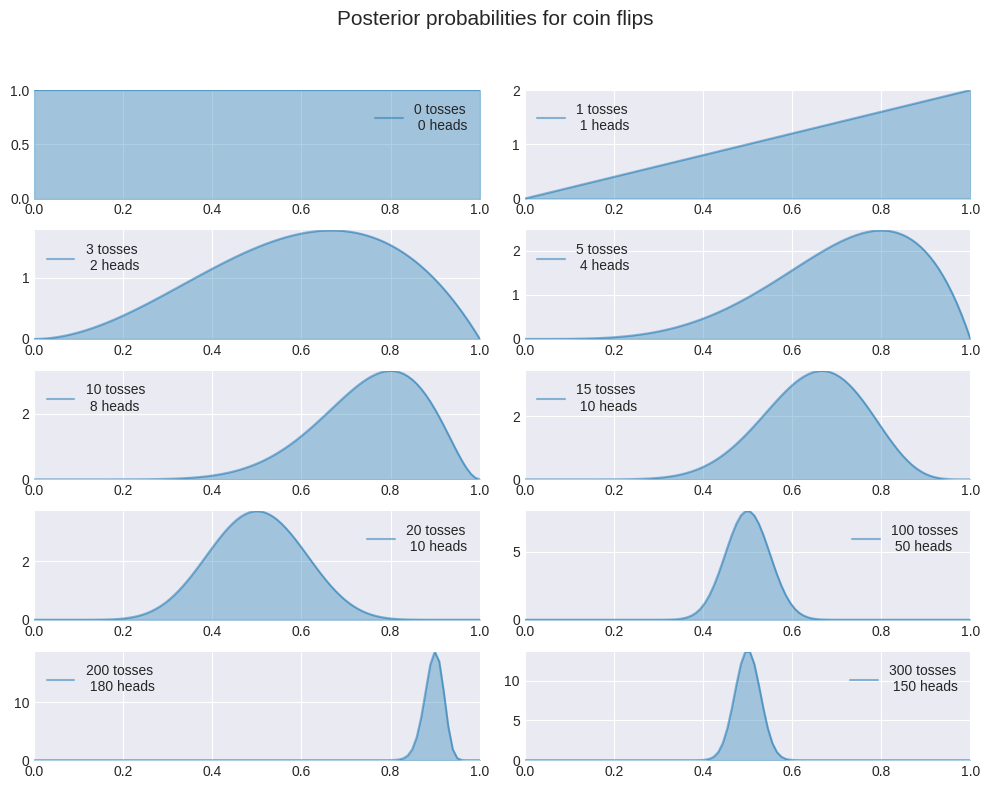

In [53]:
# play with the priors - here we manually set them but we could be sampling from a separate Beta
trials = np.array([0, 1, 3, 5, 10, 15, 20, 100, 200, 300])
heads = np.array([0, 1, 2, 4, 8, 10, 10, 50, 180, 150])
x = np.linspace(0, 1, 100)

# for simplicity we set a,b=1
plt.figure(figsize=(10,8))
for k, N in enumerate(trials):
    sx = plt.subplot(int(len(trials)/2), 2, k+1)
    posterior = stats.beta.pdf(x, 1 + heads[k], 1 + trials[k] - heads[k]) 
    plt.plot(x, posterior, alpha = 0.5, label=f'{trials[k]} tosses\n {heads[k]} heads');
    plt.fill_between(x, 0, posterior, color="#348ABD", alpha=0.4) 
    plt.legend(loc='upper left', fontsize=10)
    plt.legend()
    plt.autoscale(tight=True)
    
plt.suptitle("Posterior probabilities for coin flips", fontsize=15);
plt.tight_layout()
plt.subplots_adjust(top=0.88)

### References

- *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55* [(https://doi.org/10.7717/peerj-cs.55)](https://doi.org/10.7717/peerj-cs.55)
- [Distributions in PyMC3](https://docs.pymc.io/api/distributions.html)
- [More Details on Distributions](https://docs.pymc.io/developer_guide.html)

This linear regression example is from the original paper on PyMC3: *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55*

#### Cool Reading

- How Bayesian Analysis and Lawrence D. Stone found the Wreckage of [Air France Flight AF 447](https://www.jstor.org/stable/pdf/43288452.pdf?refreqid=excelsior%3Ae972f3a7b38b5815e1570b93dad7d269).
- Search for the gold on the sunken [SS Central America](https://www.metsci.com/wp-content/uploads/2019/08/Search-for-the-SS-Central-America-Mathematical-Treasure-Hunting-Interfaces-22-1-Jan.-Feb.-1992.pdf).